In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Using device: cuda
Mounted at /content/drive
✅ Using annotation JSON file: /content/drive/MyDrive/VisionAI/instances_val2017.json
✅ Image folder exists: /content/drive/MyDrive/VisionAI/val2017
🔧 Hyperparameters:
learning_rate: 0.0001
batch_size: 8
num_epochs: 15
num_classes: 91
subset_train: 500
subset_val: 100
image_size: 256
optimizer: Adam
num_workers: 4
loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
loading annotations into memory...
Done (t=0.52s)
creating index...
index created!
Train size: 500, Val size: 100


/tmp/ipython-input-1219449014.py:149: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-1219449014.py:171: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1219449014.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/15], Train Loss: 3.3154, Val Loss: 2.0935
✅ Checkpoint saved (best model)
Epoch [2/15], Train Loss: 2.1072, Val Loss: 1.6707
✅ Checkpoint saved (best model)
Epoch [3/15], Train Loss: 1.4155, Val Loss: 0.9811
✅ Checkpoint saved (best model)
Epoch [4/15], Train Loss: 0.9707, Val Loss: 0.7093
✅ Checkpoint saved (best model)
Epoch [5/15], Train Loss: 0.7146, Val Loss: 0.5051
✅ Checkpoint saved (best model)
Epoch [6/15], Train Loss: 0.5266, Val Loss: 0.3984
✅ Checkpoint saved (best model)
Epoch [7/15], Train Loss: 0.4147, Val Loss: 0.3135
✅ Checkpoint saved (best model)
Epoch [8/15], Train Loss: 0.3350, Val Loss: 0.2606
✅ Checkpoint saved (best model)
Epoch [9/15], Train Loss: 0.2904, Val Loss: 0.2170
✅ Checkpoint saved (best model)
Epoch [10/15], Train Loss: 0.2426, Val Loss: 0.1898
✅ Checkpoint saved (best model)
Epoch [11/15], Train Loss: 0.2234, Val Loss: 0.1728
✅ Checkpoint saved (best model)
Epoch [12/15], Train Loss: 0.2001, Val Loss: 0.1645
✅ Checkpoint saved (best model)
E

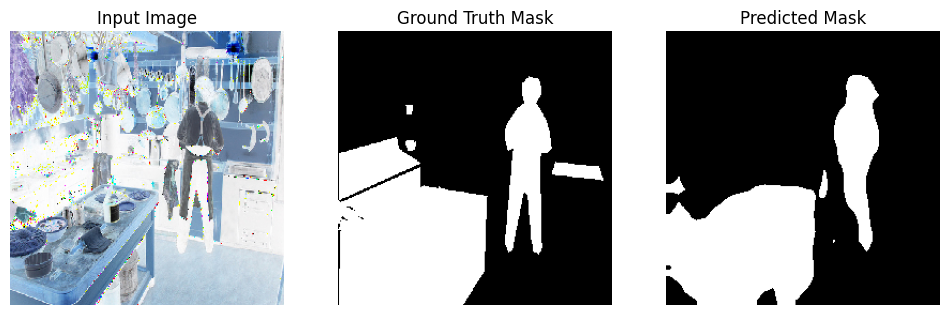

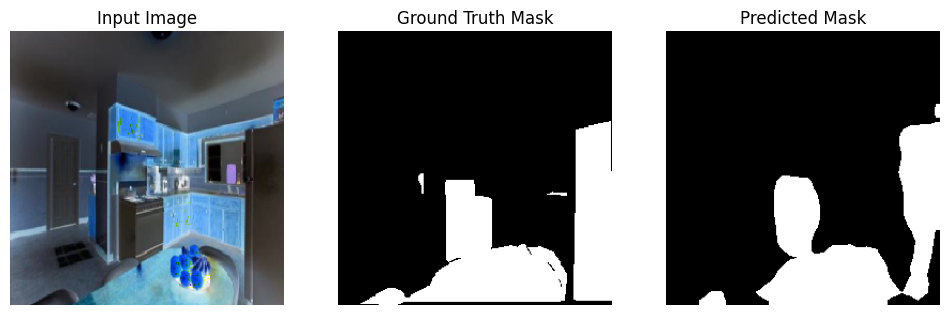

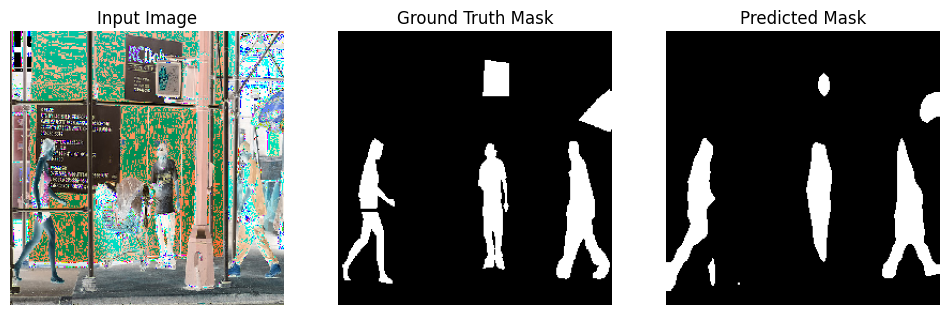

In [5]:
# =======================
# Full COCO Segmentation Training Script (Fixed)
# =======================

# =======================
# 1️⃣ Imports & Device
# =======================
import os, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models.segmentation import deeplabv3_resnet50
from pathlib import Path
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =======================
# 2️⃣ Mount Google Drive
# =======================
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# =======================
# 3️⃣ Paths & JSON
# =======================
BASE_DIR = "/content/drive/MyDrive/VisionAI"
IMG_DIR = os.path.join(BASE_DIR, "val2017")

json_files = [os.path.join(root, f)
              for root, dirs, files in os.walk(BASE_DIR)
              for f in files if f.endswith(".json")]

if not json_files:
    raise FileNotFoundError("❌ No JSON annotation file found!")
ANN_FILE = json_files[0]
print("✅ Using annotation JSON file:", ANN_FILE)

if not os.path.isdir(IMG_DIR):
    raise FileNotFoundError(f"❌ Image folder not found: {IMG_DIR}")
print("✅ Image folder exists:", IMG_DIR)

# =======================
# 4️⃣ Hyperparameters
# =======================
hyperparams = {
    "learning_rate": 1e-4,
    "batch_size": 8,
    "num_epochs": 15,
    "num_classes": 91,
    "subset_train": 500,  # Quick test mode (~500 images)
    "subset_val": 100,    # Quick validation
    "image_size": 256,
    "optimizer": "Adam",
    "num_workers": 4
}

print("🔧 Hyperparameters:")
for k, v in hyperparams.items():
    print(f"{k}: {v}")

# =======================
# 5️⃣ COCO Dataset with Albumentations
# =======================
class CocoSegmentationDataset(Dataset):
    def __init__(self, root, annFile, image_size=256, subset_size=None, augment=False):
        self.coco = COCO(annFile)
        self.root = root
        self.img_ids = list(self.coco.imgs.keys())
        if subset_size is not None:
            self.img_ids = self.img_ids[:subset_size]
        self.augment = augment

        self.transform = A.Compose([
            A.Resize(image_size, image_size, interpolation=Image.NEAREST),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=10, p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
            ToTensorV2()
        ])
        self.val_transform = A.Compose([
            A.Resize(image_size, image_size, interpolation=Image.NEAREST),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.loadImgs(img_id)[0]
        path = os.path.join(self.root, img_info['file_name'])
        image = np.array(Image.open(path).convert("RGB"))

        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in anns:
            mask = np.maximum(mask, self.coco.annToMask(ann))

        if self.augment:
            augmented = self.transform(image=image, mask=mask)
        else:
            augmented = self.val_transform(image=image, mask=mask)

        # Ensure image is float tensor for mixed precision
        image_tensor = augmented['image'].float()
        mask_tensor = augmented['mask'].long()
        return image_tensor, mask_tensor

# =======================
# 6️⃣ Datasets & DataLoaders
# =======================
train_dataset = CocoSegmentationDataset(
    root=IMG_DIR, annFile=ANN_FILE,
    image_size=hyperparams["image_size"],
    subset_size=hyperparams["subset_train"],
    augment=True
)
val_dataset = CocoSegmentationDataset(
    root=IMG_DIR, annFile=ANN_FILE,
    image_size=hyperparams["image_size"],
    subset_size=hyperparams["subset_val"],
    augment=False
)

train_loader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"],
                          shuffle=True, num_workers=hyperparams["num_workers"], pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparams["batch_size"],
                        shuffle=False, num_workers=hyperparams["num_workers"], pin_memory=True)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

# =======================
# 7️⃣ Model, Loss, Optimizer, Scheduler
# =======================
model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, hyperparams["num_classes"], kernel_size=1)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hyperparams["learning_rate"])
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)
scaler = GradScaler()

# =======================
# 8️⃣ Training Loop with Resume
# =======================
checkpoint_path = Path("/content/drive/MyDrive/VisionAI/checkpoint.pth")
start_epoch, best_val_loss, epochs_no_improve = 0, float('inf'), 0

if checkpoint_path.exists():
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    print(f"Resuming from epoch {start_epoch}")

for epoch in range(start_epoch, hyperparams["num_epochs"]):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device, dtype=torch.float), masks.to(device, dtype=torch.long)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)["out"]
            loss = criterion(outputs, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device, dtype=torch.float), masks.to(device, dtype=torch.long)
            with autocast():
                outputs = model(images)["out"]
                loss = criterion(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{hyperparams['num_epochs']}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    scheduler.step(avg_val_loss)

    # Save best checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'best_val_loss': best_val_loss
        }, checkpoint_path)
        print("✅ Checkpoint saved (best model)")
    else:
        epochs_no_improve += 1
        print(f"⚠️ Validation loss did not improve. Patience: {epochs_no_improve}/5")
    if epochs_no_improve >= 5:
        print("🛑 Early stopping triggered!")
        break

# Load best model
best_model = torch.load(checkpoint_path)
model.load_state_dict(best_model['model_state'])
print("✅ Best model loaded")

# =======================
# 9️⃣ Metrics
# =======================
def compute_metrics(model, loader, num_classes):
    model.eval()
    iou_list, dice_list = [], []
    correct, total = 0, 0
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device, dtype=torch.float)
            outputs = model(images)["out"]
            preds = outputs.argmax(1).cpu()
            masks = masks.cpu()
            correct += (preds == masks).sum().item()
            total += masks.numel()
            for cls in range(1, num_classes):
                intersection = ((preds==cls) & (masks==cls)).sum().item()
                union = ((preds==cls) | (masks==cls)).sum().item()
                pred_sum = (preds==cls).sum().item()
                mask_sum = (masks==cls).sum().item()
                if union > 0:
                    iou_list.append(intersection/union)
                    dice_list.append(2*intersection/(pred_sum + mask_sum))
    pixel_acc = 100 * correct / total
    mean_iou = 100 * np.mean(iou_list) if iou_list else 0
    mean_dice = 100 * np.mean(dice_list) if dice_list else 0
    print(f"Pixel Accuracy: {pixel_acc:.2f}%")
    print(f"Mean IoU: {mean_iou:.2f}%")
    print(f"Mean Dice Score: {mean_dice:.2f}%")

# =======================
# 10️⃣ Visualize Predictions
# =======================
def visualize_predictions(model, loader, num_images=3):
    model.eval()
    images, masks = next(iter(loader))
    with torch.no_grad():
        outputs = model(images.to(device, dtype=torch.float))["out"]
        preds = outputs.argmax(1).cpu()
    for i in range(min(num_images, len(images))):
        img = images[i].permute(1,2,0).numpy()
        img = (img * 255).astype(np.uint8)
        gt_mask = masks[i].numpy()
        pred_mask = preds[i].numpy()
        fig, axs = plt.subplots(1,3,figsize=(12,4))
        axs[0].imshow(img); axs[0].set_title("Input Image"); axs[0].axis("off")
        axs[1].imshow(gt_mask, cmap="gray"); axs[1].set_title("Ground Truth Mask"); axs[1].axis("off")
        axs[2].imshow(pred_mask, cmap="gray"); axs[2].set_title("Predicted Mask"); axs[2].axis("off")
        plt.show()

# =======================
# Run metrics & visualize
# =======================
compute_metrics(model, val_loader, hyperparams["num_classes"])
visualize_predictions(model, val_loader, num_images=3)


Using device: cuda
Mounted at /content/drive
✅ Using annotation JSON file: /content/drive/MyDrive/VisionAI/instances_val2017.json
✅ Image folder exists: /content/drive/MyDrive/VisionAI/val2017
loading annotations into memory...
Done (t=0.54s)
creating index...
index created!
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!
Train size: 5000, Val size: 5000
🔄 Resuming training from checkpoint...
⚠️ No scheduler state found in checkpoint, starting fresh scheduler.
⚠️ No scaler state found in checkpoint, starting fresh scaler.
✅ Resumed from epoch 15, best val loss: 0.1447
✅ Training complete, best model loaded
Pixel Accuracy: 93.96%
Mean IoU: 80.84%
Mean Dice Score: 89.26%


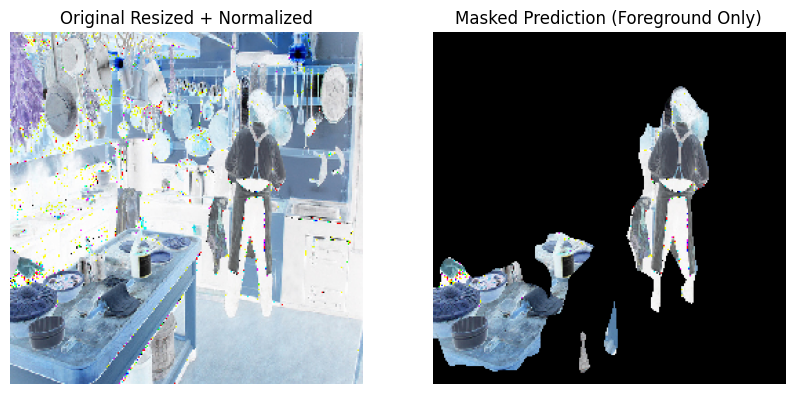

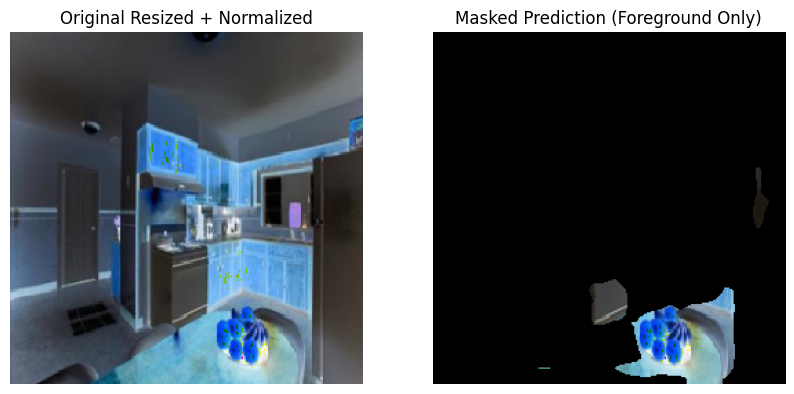

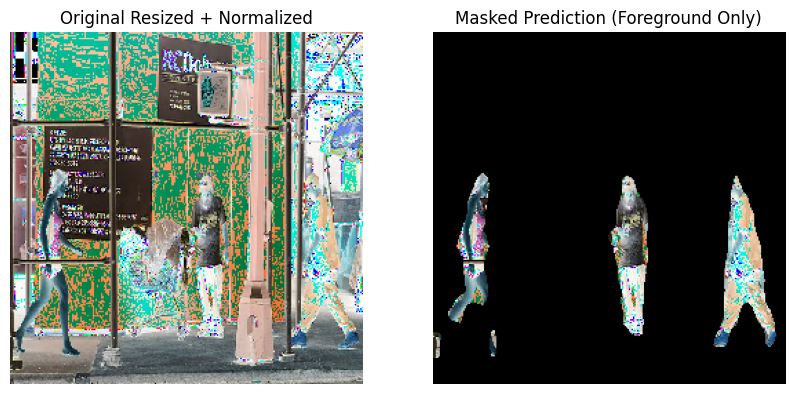

In [10]:
# =======================
# 1️⃣ Imports & Device
# =======================
import os, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models.segmentation import deeplabv3_resnet50
from pathlib import Path
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =======================
# 2️⃣ Mount Google Drive
# =======================
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# =======================
# 3️⃣ Paths & JSON
# =======================
BASE_DIR = "/content/drive/MyDrive/VisionAI"
IMG_DIR = os.path.join(BASE_DIR, "val2017")

json_files = [os.path.join(root, f)
              for root, dirs, files in os.walk(BASE_DIR)
              for f in files if f.endswith(".json")]
if not json_files:
    raise FileNotFoundError("❌ No JSON annotation file found!")
ANN_FILE = json_files[0]
print("✅ Using annotation JSON file:", ANN_FILE)

if not os.path.isdir(IMG_DIR):
    raise FileNotFoundError(f"❌ Image folder not found: {IMG_DIR}")
print("✅ Image folder exists:", IMG_DIR)

# =======================
# 4️⃣ Hyperparameters
# =======================
hyperparams = {
    "learning_rate": 1e-4,
    "batch_size": 8,
    "num_epochs": 15,
    "num_classes": 91,
    "subset_train": None,
    "subset_val": None,
    "image_size": 256,
    "optimizer": "Adam",
    "num_workers": 4
}

# =======================
# 5️⃣ COCO Dataset
# =======================
class CocoSegmentationDataset(Dataset):
    def __init__(self, root, annFile, image_size=256, subset_size=None, augment=False):
        self.coco = COCO(annFile)
        self.root = root
        self.img_ids = list(self.coco.imgs.keys())
        if subset_size is not None:
            self.img_ids = self.img_ids[:subset_size]
        self.augment = augment

        self.transform = A.Compose([
            A.Resize(image_size, image_size, interpolation=Image.NEAREST),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=10, p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
            ToTensorV2()
        ])
        self.val_transform = A.Compose([
            A.Resize(image_size, image_size, interpolation=Image.NEAREST),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.loadImgs(img_id)[0]
        path = os.path.join(self.root, img_info['file_name'])
        image = np.array(Image.open(path).convert("RGB"))

        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in anns:
            mask = np.maximum(mask, self.coco.annToMask(ann))

        if self.augment:
            augmented = self.transform(image=image, mask=mask)
        else:
            augmented = self.val_transform(image=image, mask=mask)

        image_tensor = augmented['image'].float()
        mask_tensor = augmented['mask'].long()
        return image_tensor, mask_tensor

# =======================
# 6️⃣ DataLoaders
# =======================
train_dataset = CocoSegmentationDataset(
    root=IMG_DIR, annFile=ANN_FILE,
    image_size=hyperparams["image_size"],
    subset_size=hyperparams["subset_train"],
    augment=True
)
val_dataset = CocoSegmentationDataset(
    root=IMG_DIR, annFile=ANN_FILE,
    image_size=hyperparams["image_size"],
    subset_size=hyperparams["subset_val"],
    augment=False
)

train_loader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"],
                          shuffle=True, num_workers=hyperparams["num_workers"], pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparams["batch_size"],
                        shuffle=False, num_workers=hyperparams["num_workers"], pin_memory=True)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

# =======================
# 7️⃣ Model & Training Setup
# =======================
model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, hyperparams["num_classes"], kernel_size=1)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hyperparams["learning_rate"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler()

checkpoint_path = Path("/content/drive/MyDrive/VisionAI/checkpoint.pth")

# =======================
# 8️⃣ Resume Training
# =======================
start_epoch = 0
best_val_loss = float("inf")
epochs_no_improve = 0

# ✅ Resume if checkpoint exists
if checkpoint_path.exists():
    print("🔄 Resuming training from checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])

    # Handle older checkpoints gracefully
    if 'scheduler_state' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state'])
    else:
        print("⚠️ No scheduler state found in checkpoint, starting fresh scheduler.")

    if 'scaler_state' in checkpoint:
        scaler.load_state_dict(checkpoint['scaler_state'])
    else:
        print("⚠️ No scaler state found in checkpoint, starting fresh scaler.")

    start_epoch = checkpoint.get('epoch', -1) + 1
    best_val_loss = checkpoint.get('best_val_loss', float("inf"))
    epochs_no_improve = checkpoint.get('epochs_no_improve', 0)

    print(f"✅ Resumed from epoch {start_epoch}, best val loss: {best_val_loss:.4f}")
else:
    print("🆕 No checkpoint found, starting fresh training.")


for epoch in range(start_epoch, hyperparams["num_epochs"]):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device, dtype=torch.float), masks.to(device, dtype=torch.long)
        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            outputs = model(images)["out"]
            loss = criterion(outputs, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device, dtype=torch.float), masks.to(device, dtype=torch.long)
            with autocast(device_type='cuda'):
                outputs = model(images)["out"]
                loss = criterion(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{hyperparams['num_epochs']}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    scheduler.step(avg_val_loss)

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'scheduler_state': scheduler.state_dict(),
        'scaler_state': scaler.state_dict(),
        'best_val_loss': best_val_loss,
        'epochs_no_improve': epochs_no_improve
    }, checkpoint_path)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        print("✅ New best model saved")
    else:
        epochs_no_improve += 1
        print(f"⚠️ Validation loss did not improve. Patience: {epochs_no_improve}/5")

    if epochs_no_improve >= 5:
        print("🛑 Early stopping triggered!")
        break

# Load best model
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state'])
print("✅ Training complete, best model loaded")

# =======================
# 9️⃣ Metrics
# =======================
def compute_metrics(model, loader, num_classes):
    model.eval()
    iou_list, dice_list = [], []
    correct, total = 0, 0
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device, dtype=torch.float)
            outputs = model(images)["out"]
            preds = outputs.argmax(1).cpu()
            masks = masks.cpu()
            correct += (preds == masks).sum().item()
            total += masks.numel()
            for cls in range(1, num_classes):
                intersection = ((preds==cls) & (masks==cls)).sum().item()
                union = ((preds==cls) | (masks==cls)).sum().item()
                pred_sum = (preds==cls).sum().item()
                mask_sum = (masks==cls).sum().item()
                if union > 0:
                    iou_list.append(intersection/union)
                    dice_list.append(2*intersection/(pred_sum + mask_sum))
    pixel_acc = 100 * correct / total
    mean_iou = 100 * np.mean(iou_list) if iou_list else 0
    mean_dice = 100 * np.mean(dice_list) if dice_list else 0
    print(f"Pixel Accuracy: {pixel_acc:.2f}%")
    print(f"Mean IoU: {mean_iou:.2f}%")
    print(f"Mean Dice Score: {mean_dice:.2f}%")

# =======================
# 🔟 Visualization (Masked Foreground like Example 1)
# =======================
def visualize_predictions(model, loader, num_images=3):
    model.eval()
    images, masks = next(iter(loader))
    with torch.no_grad():
        outputs = model(images.to(device, dtype=torch.float))["out"]
        preds = outputs.argmax(1).cpu()

    for i in range(min(num_images, len(images))):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = (img * 255).astype(np.uint8)

        pred_mask = preds[i].numpy()

        # create a 3-channel mask to apply on image
        masked_img = img.copy()
        masked_img[pred_mask == 0] = 0   # set background pixels to black

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(img); axs[0].set_title("Original Resized + Normalized"); axs[0].axis("off")
        axs[1].imshow(masked_img); axs[1].set_title("Masked Prediction (Foreground Only)"); axs[1].axis("off")
        plt.show()


# =======================
# Run Metrics & Visualization
# =======================
compute_metrics(model, val_loader, hyperparams["num_classes"])
visualize_predictions(model, val_loader, num_images=3)

